In [2]:
#Import of preprocessedText Data
import pandas as pd

df = pd.read_csv("PreprocessedText.csv")
df.head()

,doc_id,country,year,strategy_name,file_name,text
0,CAN_2022,CAN,2022,Canada's National Quantum Strategy,CAN_2022_Canada's National Quantum Strategy.pdf,io executive summary advance quantum science p...
1,GER_2023,GER,2023,Quantum Technologies Conceptual Framework Prog...,GER_2023_Quantum Technologies Conceptual Frame...,1 exploit potential quantum technology germany...
2,UK_2023,UK,2023,National Quantum Strategy,UK_2023_National Quantum Strategy.pdf,ministerial foreword first generation quantum ...
3,USA_2018,USA,2018,NATIONAL STRATEGIC OVERVIEW FOR QUANTUM INFO...,USA_2018_NATIONAL STRATEGIC OVERVIEW FOR QUAN...,lsn report 2017 operationalizing software defi...


In [18]:
# Creation of Dictionary and Corpus 
QH_DICT = {
    "government": [
        "government", "state", "public sector", "ministry", "agency",
        "regulation", "policy", "legislation", "governance",
        "public funding", "subsidy", "public procurement"
    ],
    "society": [
        "society", "civil society", "citizen", "public", "community",
        "ngo", "non profit", "foundation", "participation",
        "public engagement", "social impact", "trust"
    ],
    "industry": [
        "industry", "business", "private sector", "company", "firm",
        "enterprise", "startup", "sme", "corporation",
        "commercialization", "market", "value chain"
    ],
    "academia": [
        "academia", "academic", "university", "higher education",
        "research institution", "research", "scientific",
        "laboratory", "technology transfer"
    ]
}

In [19]:
import nltk
from nltk.corpus import wordnet

def expand_lexical(category_list):
    expanded = set(category_list)
    for word in category_list:
        # Get synsets for the word (filtered for Nouns)
        syns = wordnet.synsets(word.replace(" ", "_"), pos=wordnet.NOUN)
        for s in syns:
            # Add Synonyms
            expanded.update([l.name().replace('_', ' ') for l in s.lemmas()])
            # Add Hyponyms (specific types: e.g., 'ministry' -> 'foreign office')
            for hypo in s.hyponyms():
                expanded.update([l.name().replace('_', ' ') for l in hypo.lemmas()])
    return sorted(list(expanded))

# Usage:
expanded_gov = expand_lexical(QH_DICT["government"])
expanded_academia = expand_lexical(QH_DICT["academia"])
expanded_industry = expand_lexical(QH_DICT["industry"])
expanded_society = expand_lexical(QH_DICT["society"])
print(expanded_academia)
print(expanded_gov)
print(expanded_industry)
print(expanded_society)


['Open University', 'Oxbridge', 'academe', 'academia', 'academic', 'academician', 'bio lab', 'biology lab', 'biology laboratory', 'canvass', 'chem lab', 'chemistry lab', 'chemistry laboratory', 'city university', 'defense laboratory', 'empirical research', 'enquiry', 'experiment', 'experimentation', 'faculty member', 'field work', 'gown', 'heraldry', 'higher education', 'inquiry', 'investigation', 'lab', 'laboratory', 'market research', 'marketing research', 'microscopy', 'multiversity', 'nature study', 'operations research', 'opinion poll', 'physics lab', 'physics laboratory', 'poll', 'probe', 'prof', 'professor', 'public opinion poll', 'redbrick university', 'research', 'research institution', 'research lab', 'research laboratory', 'research project', 'science lab', 'science laboratory', 'scientific', 'scientific research', 'technology transfer', 'testing ground', 'university', 'varsity']
['AFISR', 'AI', 'ARDA', 'Advanced Research and Development Activity', 'African country', 'Africa

In [21]:
from gensim.models import Word2Vec

# Your corpus: List of tokenized sentences
corpus = [['university', 'research', 'science'], ...]  # From quantum strategies

model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)
seeds = ['university', 'industry', 'government', 'civil_society']

expanded = {}
for seed in seeds:
    similar = model.wv.most_similar(seed, topn=10)
    expanded[seed] = [word for word, sim in similar if sim > 0.6]  # Adjust threshold

print(expanded)  # e.g., 'university': ['academy', 'institute', ...]


TypeError: 'ellipsis' object is not iterable

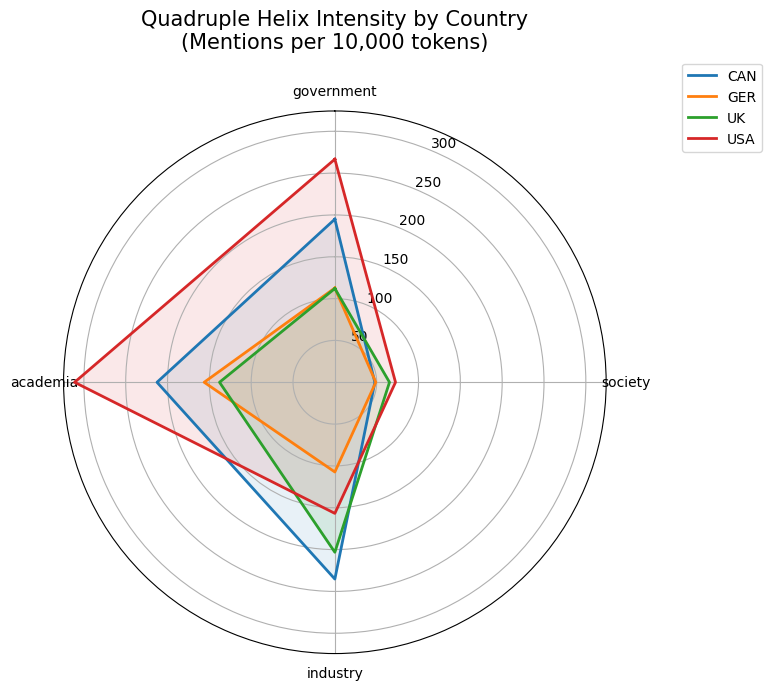

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# 2. Helper functions for robust counting and tokenization
_token_re = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)

def n_tokens(text: str) -> int:
    """Returns total word count of the text."""
    return len(_token_re.findall(str(text)))

def build_phrase_pattern(phrase: str) -> re.Pattern:
    """Creates a regex pattern for whole-word matching of phrases."""
    parts = [re.escape(p) for p in phrase.lower().strip().split()]
    pat = r"\b" + r"\s+".join(parts) + r"\b"
    return re.compile(pat, flags=re.IGNORECASE)

# Precompile patterns for performance
compiled_patterns = {
    area: [build_phrase_pattern(term) for term in terms]
    for area, terms in QH_DICT.items()
}

def count_mentions(text: str, patterns: list[re.Pattern]) -> int:
    """Counts regex matches in text."""
    return sum(len(p.findall(str(text))) for p in patterns)

# 3. Load data and process
df = pd.read_csv("PreprocessedText.csv")

# Calculate document length and mentions per helix
df["n_tokens"] = df["text"].apply(n_tokens)
for area, patterns in compiled_patterns.items():
    df[area] = df["text"].apply(lambda t: count_mentions(t, patterns))

# 4. Aggregate and Normalize (Mentions per 10,000 tokens)
qh_cols = list(QH_DICT.keys())
country_sum = df.groupby("country")[qh_cols + ["n_tokens"]].sum()

# Intensity calculation: (Mentions / Total Tokens) * 10,000
profile = (country_sum[qh_cols].div(country_sum["n_tokens"], axis=0) * 10000).fillna(0)

# 5. Build the Radar Chart
labels = qh_cols
num_vars = len(labels)

# Compute angles for the plot
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Adjust plot orientation
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Set axis labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Plot each country's data
for country, row in profile.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, label=country)
    ax.fill(angles, values, alpha=0.1)

# Add title and legend
plt.title("Quadruple Helix Intensity by Country\n(Mentions per 10,000 tokens)", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig("RQ1_Radar_Chart.png")
plt.show()

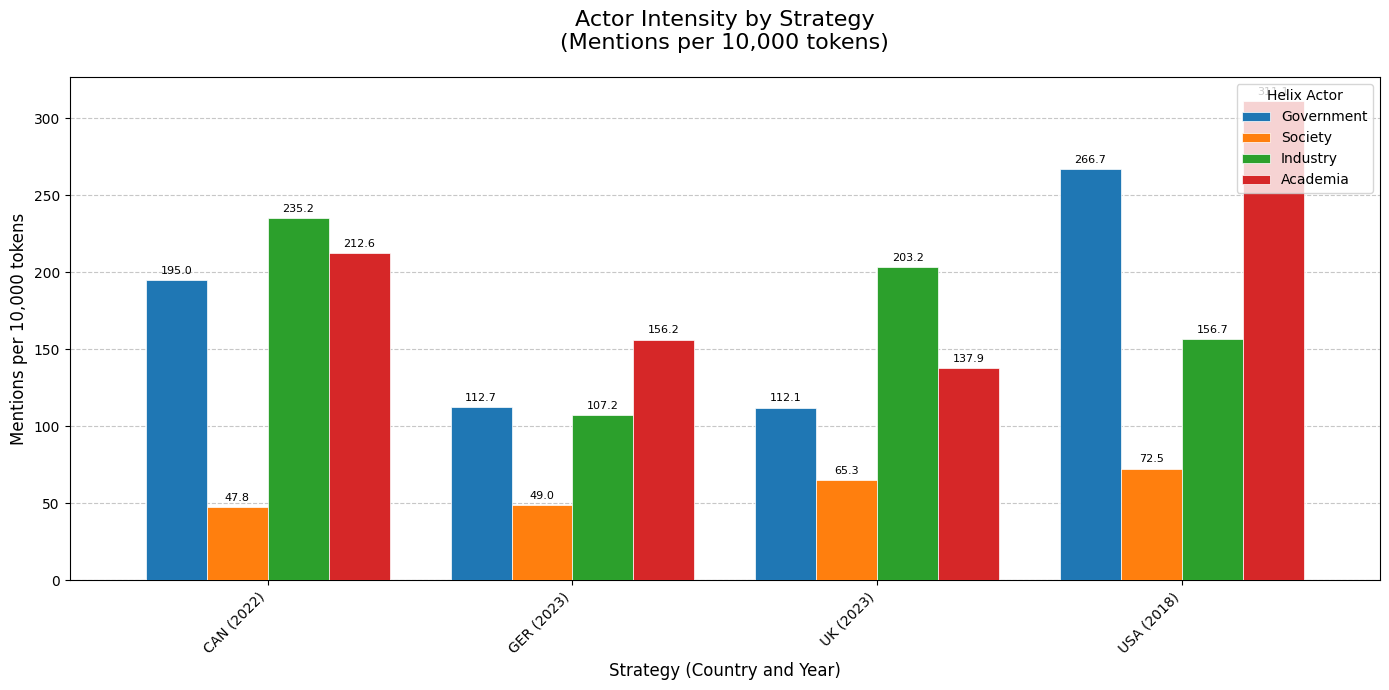

In [11]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the Quadruple Helix Dictionary
QH_DICT = {
    "Government": [
        "government", "state", "public sector", "ministry", "agency",
        "regulation", "policy", "legislation", "governance",
        "public funding", "subsidy", "public procurement"
    ],
    "Society": [
        "society", "civil society", "citizen", "public", "community",
        "ngo", "non profit", "foundation", "participation",
        "public engagement", "social impact", "trust"
    ],
    "Industry": [
        "industry", "business", "private sector", "company", "firm",
        "enterprise", "startup", "sme", "corporation",
        "commercialization", "market", "value chain"
    ],
    "Academia": [
        "academia", "academic", "university", "higher education",
        "research institution", "research", "scientific",
        "laboratory", "technology transfer"
    ]
}

# 2. Robust Counting Helpers
_token_re = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)

def n_tokens(text: str) -> int:
    return len(_token_re.findall(str(text)))

def build_phrase_pattern(phrase: str) -> re.Pattern:
    parts = [re.escape(p) for p in phrase.lower().strip().split()]
    pat = r"\b" + r"\s+".join(parts) + r"\b"
    return re.compile(pat, flags=re.IGNORECASE)

compiled_patterns = {
    area: [build_phrase_pattern(term) for term in terms]
    for area, terms in QH_DICT.items()
}

def count_area_regex(text: str, patterns: list[re.Pattern]) -> int:
    return sum(len(p.findall(str(text))) for p in patterns)

# 3. Load and Process Data
df = pd.read_csv("PreprocessedText.csv")

# Create a combined Country-Year label for the X-axis
df["label"] = df["country"] + " (" + df["year"].astype(str) + ")"

# Calculate word counts and raw helix counts
df["n_tokens"] = df["text"].apply(n_tokens)
qh_cols = list(QH_DICT.keys())

for area, patterns in compiled_patterns.items():
    df[area] = df["text"].apply(lambda t: count_area_regex(t, patterns))

# 4. Normalize: Calculate Intensity (Mentions per 10,000 tokens)
# We sum everything first in case a country has multiple documents
agg_df = df.groupby("label")[qh_cols + ["n_tokens"]].sum()

for col in qh_cols:
    agg_df[col] = (agg_df[col] / agg_df["n_tokens"]) * 10000

# 5. Plot the Grouped Bar Chart
ax = agg_df[qh_cols].plot(
    kind="bar",
    figsize=(14, 7),
    width=0.8,
    zorder=3,
    edgecolor='white',
    linewidth=0.5
)

# Customizing labels and style
plt.title("Actor Intensity by Strategy\n(Mentions per 10,000 tokens)", fontsize=16, pad=20)
plt.ylabel("Mentions per 10,000 tokens", fontsize=12)
plt.xlabel("Strategy (Country and Year)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
plt.legend(title="Helix Actor", frameon=True, shadow=False, loc='upper right')

# Add values on top of bars (rounded to 1 decimal)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)

plt.tight_layout()
plt.savefig("RQ1_Normalized_Mentions_BarChart.png", dpi=300)
plt.show()

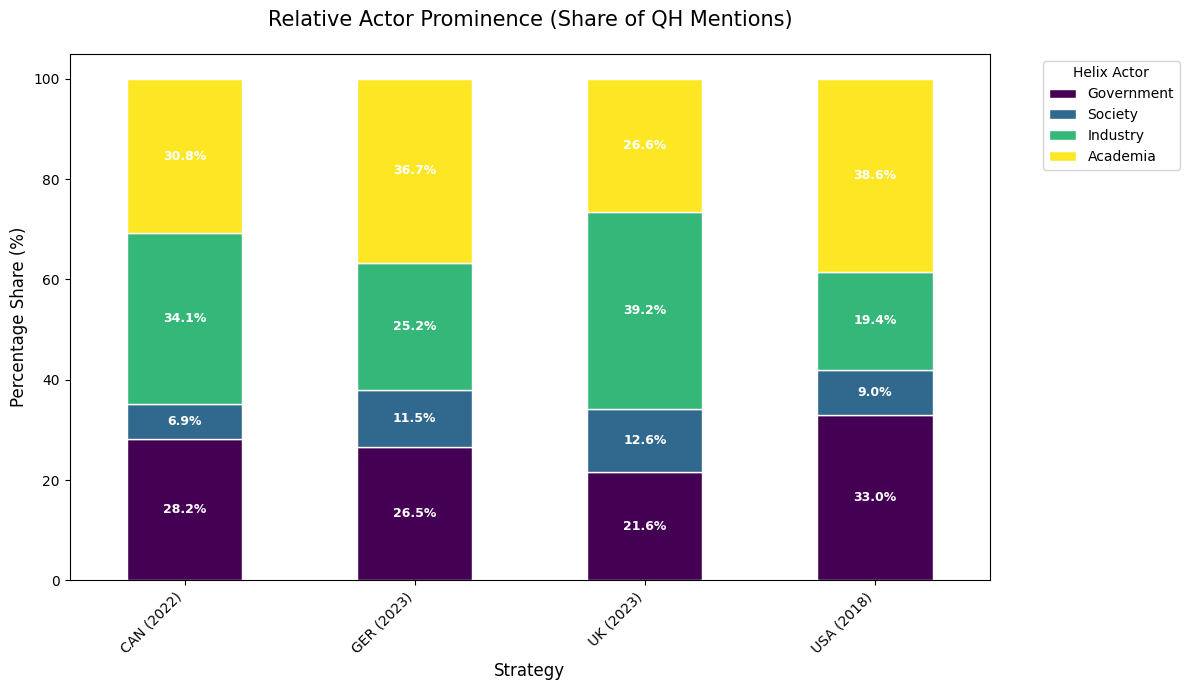

In [14]:
import pandas as pd
import re
import matplotlib.pyplot as plt


def build_phrase_pattern(phrase):
    parts = [re.escape(p) for p in phrase.lower().strip().split()]
    return re.compile(r"\b" + r"\s+".join(parts) + r"\b", flags=re.IGNORECASE)

compiled = {area: [build_phrase_pattern(t) for t in terms] for area, terms in QH_DICT.items()}

def count_mentions(text, patterns):
    return sum(len(p.findall(str(text))) for p in patterns)

# 2. Data Processing
df = pd.read_csv("PreprocessedText.csv")
df["label"] = df["country"] + " (" + df["year"].astype(str) + ")"
qh_cols = list(QH_DICT.keys())

for area, patterns in compiled.items():
    df[area] = df["text"].apply(lambda t: count_mentions(t, patterns))

# 3. Aggregate and Calculate Shares (%)
agg_df = df.groupby("label")[qh_cols].sum()
# Normalize each row so it sums to 100%
shares_df = agg_df.div(agg_df.sum(axis=1), axis=0) * 100

# 4. Plotting
ax = shares_df.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="viridis", edgecolor="white")

plt.title("Relative Actor Prominence (Share of QH Mentions)", fontsize=15, pad=20)
plt.ylabel("Percentage Share (%)", fontsize=12)
plt.xlabel("Strategy", fontsize=12)
plt.legend(title="Helix Actor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")

# Add percentage labels inside the bars (only for segments > 5% for readability)
for c in ax.containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9, color="white", fontweight="bold")

plt.tight_layout()
plt.savefig("RQ1_Stacked_Bar_Shares.png", dpi=300)
plt.show()

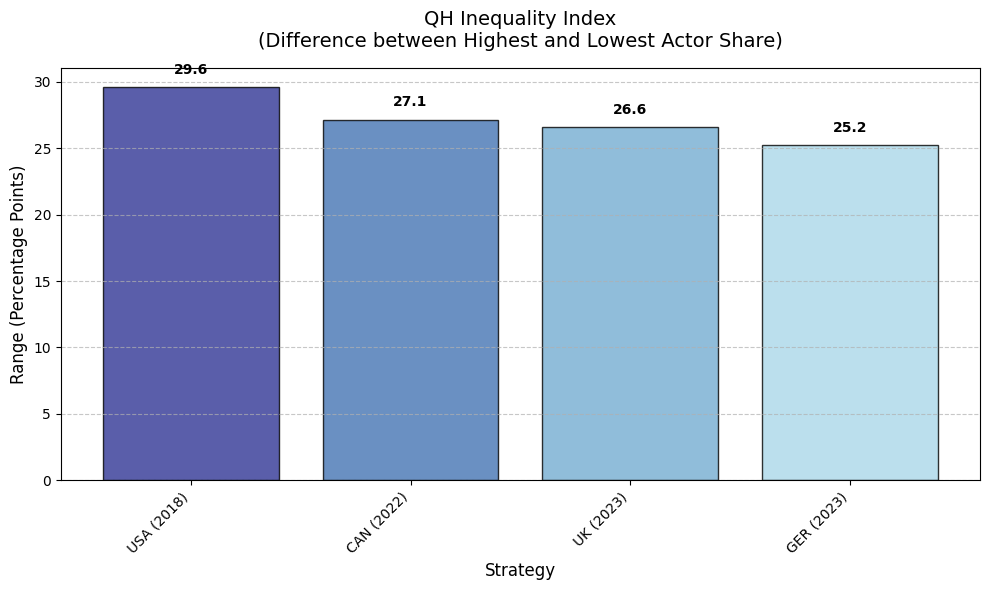

In [16]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np


def build_phrase_pattern(phrase):
    parts = [re.escape(p) for p in phrase.lower().strip().split()]
    return re.compile(r"\b" + r"\s+".join(parts) + r"\b", flags=re.IGNORECASE)

compiled = {area: [build_phrase_pattern(t) for t in terms] for area, terms in QH_DICT.items()}

def count_mentions(text, patterns):
    return sum(len(p.findall(str(text))) for p in patterns)

# 2. Data Processing
df = pd.read_csv("PreprocessedText.csv")
df["label"] = df["country"] + " (" + df["year"].astype(str) + ")"
qh_cols = list(QH_DICT.keys())

for area, patterns in compiled.items():
    df[area] = df["text"].apply(lambda t: count_mentions(t, patterns))

# 3. Calculate Inequality (QH Range)
agg_df = df.groupby("label")[qh_cols].sum()
shares_df = agg_df.div(agg_df.sum(axis=1), axis=0) * 100

# Range = Max % - Min %
ineq_df = pd.DataFrame(index=shares_df.index)
ineq_df["qh_range"] = shares_df.max(axis=1) - shares_df.min(axis=1)
ineq_df = ineq_df.sort_values("qh_range", ascending=False) # Rank by most unequal

# 4. Plotting
plt.figure(figsize=(10, 6))
# Create a color gradient (red for high inequality, blue for lower)
colors = plt.cm.RdYlBu_r(np.linspace(0, 0.3, len(ineq_df))) 

plt.bar(ineq_df.index, ineq_df["qh_range"], color=colors, edgecolor="black", alpha=0.8)

plt.title("QH Inequality Index\n(Difference between Highest and Lowest Actor Share)", fontsize=14, pad=15)
plt.ylabel("Range (Percentage Points)", fontsize=12)
plt.xlabel("Strategy", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact value labels on top of bars
for i, v in enumerate(ineq_df["qh_range"]):
    plt.text(i, v + 1, f'{v:.1f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("RQ1_Inequality_Plot.png", dpi=300)
plt.show()